## Nearest Neighbor

In [52]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_in, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

sns.set(style="white")

In [54]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(1, 2, 3, 5, 7, 15, 16, 18))

In [55]:
local = df[df['Origin'] == 'ORD']
local = local.drop('Origin', axis=1)
local['Delayed'] = (local['DepDelay'] >= 15).astype(np.int) 
local = local.drop('DepDelay', axis=1).dropna() 

In [56]:
print(local.head(5))

      Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Delayed
6367      1           1          1         951        1235       599        0
6368      1           2          2         951        1235       599        0
6369      1           3          3         951        1235       599        0
6370      1           4          4         951        1235       599        1
6371      1           5          5         951        1235       599        0


In [62]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    return X_train, X_test, y_train, y_test

In [63]:
X_train_valid, X_test, y_train_valid, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

In [64]:
assert_equal(isinstance(X_train_valid, pd.DataFrame), True)
assert_equal(isinstance(X_test, pd.DataFrame), True)
assert_equal(isinstance(y_train_valid, pd.DataFrame), True)
assert_equal(isinstance(y_test, pd.DataFrame), True)

assert_equal(len(X_train_valid) - np.round(len(local) * 0.8) <= 1, True)
assert_equal(len(X_test) - np.round(len(local) * 0.2) <= 1, True)
assert_equal(len(y_train_valid) - np.round(len(local) * 0.8) <= 1, True)
assert_equal(len(y_test) - np.round(len(local) * 0.2) <= 1, True)

assert_index_equal(X_train_valid.columns, local.columns.drop('Delayed'))
assert_index_equal(X_test.columns, local.columns.drop('Delayed'))
assert_equal(y_train_valid.columns, pd.Index(['Delayed']))
assert_equal(y_test.columns, pd.Index(['Delayed']))

In [65]:
X_train, X_valid, y_train, y_valid = split(
    df=X_train_valid.join(y_train_valid),
        test_column=['Delayed'],
    test_size=0.25,
    random_state=check_random_state(0)
    )

In [66]:
assert_equal(len(X_train) - np.round(len(local) * 0.6) <= 1, True)
assert_equal(len(X_valid) - np.round(len(local) * 0.2) <= 1, True)
assert_equal(len(y_train) - np.round(len(local) * 0.6) <= 1, True)
assert_equal(len(X_valid) - np.round(len(local) * 0.2) <= 1, True)

assert_index_equal(X_train.index[:5], pd.Int64Index([5903153, 1200840, 4524718, 2419368, 4017270]))
assert_index_equal(X_valid.index[:5], pd.Int64Index([722372, 3342898, 4673529,  896758, 1744337]))
assert_index_equal(y_train.index, X_train.index)
assert_index_equal(y_valid.index, X_valid.index)

In [67]:
print(local.min())

Month           1
DayofMonth      1
DayOfWeek       1
CRSDepTime    530
CRSArrTime      1
Distance       67
Delayed         0
dtype: int64


In [68]:
print(local.max())

Month           12
DayofMonth      31
DayOfWeek        7
CRSDepTime    2245
CRSArrTime    2359
Distance      4243
Delayed          1
dtype: int64


In [71]:
def normalize(df):
    '''
    Takes a dataframe and normlizes features to be in range [0, 1].
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    new=(df-df.min())/(df.max()-df.min())
    return new

In [72]:
X_train_normal, X_valid_normal = map(normalize, [X_train, X_valid])
print(X_train_normal.min())

Month         0.0
DayofMonth    0.0
DayOfWeek     0.0
CRSDepTime    0.0
CRSArrTime    0.0
Distance      0.0
dtype: float64


In [73]:
print(X_train_normal.max())

Month         1.0
DayofMonth    1.0
DayOfWeek     1.0
CRSDepTime    1.0
CRSArrTime    1.0
Distance      1.0
dtype: float64


In [74]:
df0 = pd.DataFrame({
    'a': [0, 1, 2, 3, 4],
    'b': [-50, -20, 10, 45, 50],
    'c': [-200, 450, 100, 500, -500]
    })

test1 = normalize(df0)
answer1 = pd.DataFrame({
    'a': [0., 0.25, 0.5, 0.75, 1.],
    'b': [0., 0.3, 0.6, 0.95, 1.],
    'c': [0.3, 0.95, 0.6, 1., 0.]
    })
assert_frame_equal(test1, answer1)

In [77]:
def train_knn(X, y, n_neighbors):
    '''
    Fits a $k$-Nearest Neighbors on the training data.
    Returns the trained model (an `sklearn.neighbors.KNeighborsClassifier` object).
    
    Parameters
    ----------
    X: A pandas.DataFrame. Training attributes.
    y: A pandas.DataFrame. Truth labels.
    n_neighbors: Number of neighbors to use in kNN.
    
    Returns
    -------
    An sklearn.neighbors.KNeighborsClassifier object.
    '''
    knc = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knc.fit(X, y)
    return knc

In [78]:
test_X_train = pd.DataFrame({
    'a': np.random.rand(100),
    'b': np.random.rand(100)
    })
test_y_train = pd.DataFrame({
    'y': np.floor(np.random.rand(100) * 2)
    })

test2 = train_knn(test_X_train, test_y_train, 1)

assert_equal(isinstance(test2, neighbors.KNeighborsClassifier), True)
assert_equal(test2.n_neighbors, 1)
assert_array_almost_equal(test2._fit_X, test_X_train)
assert_array_equal(test2._y, test_y_train.values.ravel())

# test with different n_neighbors
test3 = train_knn(test_X_train, test_y_train, 5)
assert_equal(test3.n_neighbors, 5)
assert_array_almost_equal(test3._fit_X, test_X_train)
assert_array_equal(test3._y, test_y_train.values.ravel())

In [91]:
def predict_knn(model, X):
    '''
    Fits an `sklearn.neighbors.KNeighborsClassifier` model on `X` and
    returns a `numpy.ndarray` of predicted values.
    
    Parameters
    ----------
    model: An sklearn.neighbors.KNeighborsClassifier object.
    X: pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame. Has one column "Delayed".
    '''
    z = model.predict(X)
    prediction=pd.DataFrame(z,columns=['Delayed'])
    return prediction

In [92]:
test4_model = train_knn(X_train, y_train, 1)
test4 = predict_knn(test4_model, X_valid)[:10]
answer4 = pd.DataFrame({
    'Delayed': [1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
    })

assert_equal(isinstance(test4, pd.DataFrame), True)
assert_frame_equal(test4, answer4)

test5_model = train_knn(X_train, y_train, 3)
test5 = predict_knn(test5_model, X_valid)[:10]
answer5 = pd.DataFrame({
    'Delayed': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

    })
assert_frame_equal(test5, answer5)

test6_model = train_knn(X_train, y_train, 5)
test6 = predict_knn(test6_model, X_valid)[:10]
answer6 = pd.DataFrame({
    'Delayed': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    })
assert_frame_equal(test6, answer6)

In [102]:
def compute_accuracy(X_train, X_valid, y_train, y_valid, start=1, end=51):
    '''
    Find accuracy scores for kNN classifers
    with n_neighbors = start, start + 1, start + 2, ..., end - 1.
    Returns a Numpy array of length end - start.
    For example, if start=1 and end=4, then len(scores) = 3, and
    scores[0] cooresponds to the accuracy of kNN with k=1,
    scores[1] the accuracy of kNN with k=2, ..., and
    scores[2] the accuracy of KNN with k=3.
    
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    X_valid: A pandas.DataFrame
    y_train: A pandas.DataFrame
    y_valid: A pandas.DataFrame
    start: An int.
    end: An int.
    
    Returns
    -------
    A numpy.ndarray
    '''
    scores=np.empty(0)
    for nbrs in range(start,end):
        knc = neighbors.KNeighborsClassifier(n_neighbors=nbrs)
        knc.fit(X_train, y_train)
        score=knc.score(X_valid, y_valid)
        scores=np.append(scores,score)
    return scores

In [103]:
test6 = compute_accuracy(X_train, X_valid, y_train, y_valid, 2, 5)
assert_array_almost_equal(test6, [0.78034487, 0.74846536, 0.78298197])

In [104]:
scores = compute_accuracy(X_train, X_valid, y_train, y_valid, 1, 51)
k_best = np.argmax(scores) + 1
print('The best model: k = {}'.format(k_best))

The best model: k = 48


In [105]:
X_train_valid_normal, X_test_normal = map(normalize, [X_train_valid, X_test])

final_model = train_knn(X_train_valid_normal, y_train_valid, n_neighbors=k_best)
y_pred = predict_knn(final_model, X_test_normal)

accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of k-Nearest Neighbors is {:2.1f}%.".format(accuracy * 100))

The accuracy of k-Nearest Neighbors is 82.0%.


In [142]:
def plot_confusion(): 
    '''
    Plots a confusion matrix using numpy.histogram2d() and seaborn.heatmap().
    Returns a maptlotlib.axes.Axes instance.
    '''
    fig, ax = plt.subplots()
    names = ['Not delayed', 'Delayed']
    pts, xe, ye = np.histogram2d(np.array(y_test).flatten(), np.array(y_pred).flatten(), bins=2)
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title('Confusion matrix for KNN (k=48)')
    return ax

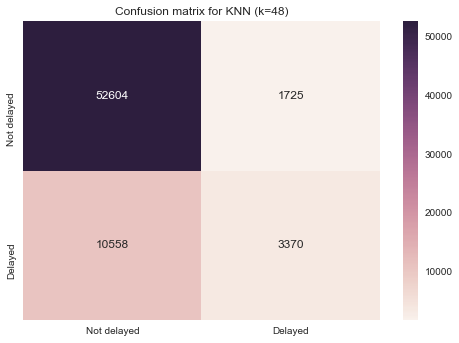

In [144]:
ax=plot_confusion()

In [145]:
assert_equal(isinstance(ax, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

texts = [t.get_text() for t in ax.texts]
assert_equal(texts, ['10558', '3370', '52604', '1725'])
             
x_tick_labels = [l.get_text() for l in ax.get_xticklabels()]
y_tick_labels = [l.get_text() for l in ax.get_yticklabels()]
assert_equal(y_tick_labels, ['Delayed', 'Not delayed'])

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")

## Support Vector Machine

In [2]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_in, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

sns.set(style="white")

In [3]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(5, 8, 15, 16, 18))

In [4]:
local = df[(df['Origin'] == 'ORD') & (df['UniqueCarrier'] == 'AA')]
local = local.drop(['UniqueCarrier', 'Origin'], axis=1) 
local['Delayed'] = (local['DepDelay'] > 0).astype(np.int) 
local = local.drop('DepDelay', axis=1).dropna() 

In [6]:
print('Delayed: {}\nNot delayed: {}'.format(
    (local.Delayed == 0).sum(),
    (local.Delayed == 1).sum()
    ))

Delayed: 61932
Not delayed: 44006


In [6]:
print(local.head(5))

        CRSDepTime  Distance  Delayed
398444        1905      1846        1
398445        1905      1846        1
398446        1905      1846        1
398447        1905      1846        0
398448        1905      1846        1


In [5]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of numpy.ndarrays
    '''
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_train=np.array(y_train).flatten()
    y_test=np.array(y_test).flatten()
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.4,
    random_state=check_random_state(0)
    )

In [7]:
n_samples_train, n_features_train = X_train.shape
n_samples_test, n_features_test = X_test.shape

assert_equal(n_features_train, 2)
assert_equal(n_features_test, 2)
n_features = n_features_train

assert_equal(np.abs(n_samples_train - np.round(len(local) * 0.6)) <= 1, True)
assert_equal(np.abs(n_samples_test - np.round(len(local) * 0.4)) <= 1, True)

assert_array_equal(X_train[:5],
    np.array(
        [[ 1500.,  1846.],
         [ 1415.,   802.],
         [ 1138.,   409.],
         [ 1649.,   723.],
         [ 1835.,   678.]]
        ))
assert_array_equal(X_test[:5],
    np.array(
        [[  645.,  1745.],
         [  620.,   622.],
         [  645.,  1745.],
         [ 2040.,   678.],
         [  835.,   268.]]
        ))

assert_array_equal(y_train[:10], np.array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1]))
assert_array_equal(y_test[:10], np.array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1]))


In [29]:
def standardize(df):
    '''
    Takes a dataframe and normlizes features to be in range [0, 1].
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    df_std =(df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
    scaled = df_std * 2 -1
    return scaled

In [30]:
df0 = pd.DataFrame({
    'a': [0, 1, 2, 3, 4],
    'b': [-50, -20, 10, 45, 50],
    'c': [-200, 450, 100, 500, -500]
    })
test1 = standardize(df0)
answer1 = pd.DataFrame({
        'a': [ -1., -0.5, 0., 0.5, 1.],
        'b': [ -1., -0.4, 0.2, 0.9, 1.],
        'c': [ -0.4, 0.9, 0.2, 1., -1.]
    })
assert_frame_equal(test1, answer1)

In [31]:
X_train_scaled, X_test_scaled = map(standardize, [X_train, X_test])

In [33]:
def fit_and_predict(X_train, y_train, X_test, kernel):
    '''
    Fits a Support Vector Machine on the training data on "X_train" and "y_train".
    Returns the predicted values on "X_test".
    
    Parameters
    ----------
    X_train: A numpy.ndarray
    y_train: A numpy.ndarray
    X_test: A numpy.ndarray
    kernel: A string that specifies kernel to be used in SVM
    
    Returns
    -------
    model: An svm.SVC instance trained on "X_train" and "y_train"
    y_pred: A numpy array. Values predicted by "model" on "X_test"
    '''
    svc = svm.SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred=svc.predict(X_test)
    return svc, y_pred

In [34]:
X_train_t = [[-2, -1], [-1, -1], [-1, -2], [1, 1], [1, 2], [2, 1]]
y_train_t = [1, 1, 1, 2, 2, 2]
X_test_t = [[-1, -1], [2, 2], [3, 2]]
y_test_t = [1, 2, 2]

model1, pred1 = fit_and_predict(X_train_t, y_train_t, X_test_t, 'linear')
assert_equal(isinstance(model1, svm.SVC), True)
assert_equal(model1.kernel, 'linear')
assert_array_equal(pred1, y_test_t)

model2, pred2 = fit_and_predict(X_train_t, y_train_t, X_test_t, 'rbf')
assert_equal(model2.kernel, 'rbf')
assert_array_equal(pred2, y_test_t)

In [35]:
clf, y_pred = fit_and_predict(X_train_scaled, y_train, X_test_scaled, 'rbf')

In [36]:
print(accuracy_score(y_test, y_pred))

0.593779497829


In [37]:
def plot_confusion():
    '''
    Plots a confusion matrix using numpy.histogram2d() and seaborn.heatmap().
    Returns a maptlotlib.axes.Axes instance.
    '''
    fig, ax = plt.subplots()
    names = ['Not delayed', 'Delayed']
    pts, xe, ye = np.histogram2d(np.array(y_test).flatten(), np.array(y_pred).flatten(), bins=2)
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title('Confusion matrix for SVM')
    return ax

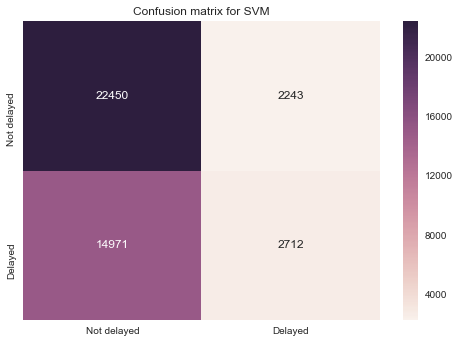

In [39]:
ax=plot_confusion()

In [40]:
assert_equal(isinstance(ax, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

texts = [t.get_text() for t in ax.texts]
assert_equal(texts, ['14971', '2712', '22450', '2243'])
             
x_tick_labels = [l.get_text() for l in ax.get_xticklabels()]
y_tick_labels = [l.get_text() for l in ax.get_yticklabels()]
assert_equal(y_tick_labels, ['Delayed', 'Not delayed'])

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")

## Naive Bayes

In [41]:
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal

In [136]:
def separate_by_class(X, y):
    '''
    Separate the training set ("X") by class value ("y")
    so that we can calculate statistics for each class.
    
    Parameters
    ----------
    X: A 2d numpy array
    y: A 1d numpy array
    Returns
    -------
    A dictionary of 2d numpy arrays
    '''
    d=np.column_stack((X, y))
    separated = {}
    for i in range(len(d)):
        vector = d[i]
        if (vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector[:-1])
    for j in range(len(separated)):
        separated[j]=np.vstack(separated[j])
    return separated

In [137]:
X_t = np.array( [[2, 21], [1, 20], [3, 22]] )
y_t = np.array( [1, 0, 1] )
separated_t = separate_by_class(X_t, y_t)
assert_array_equal(separated_t[0], np.array( [ [1, 20] ] ))
assert_array_equal(separated_t[1], np.array( [ [2, 21], [3, 22] ] ))

In [140]:
def calculate_mean(array):
    '''
    Calculates the mean of each column, i.e. each attribute.
    
    Parameters
    ----------
    A 1d or 2d numpy array
    
    Returns
    -------
    A 1d or 2d numpy array
    '''
    mean=np.mean(array,axis=0)
    return mean

In [141]:
array_t = np.array( [ [1, 4, 7], [2, 5, 6], [3, 6, 8] ] )
mean_t = calculate_mean(array_t)
assert_array_equal(mean_t, np.array( [2., 5., 7.] ))

In [142]:
def calculate_stdev(array):
    '''
    Calculates the standard deviation (N-1 method) of each column, i.e. each attribute.

    Parameters
    ----------
    A 1d or 2d numpy array
    
    Returns
    -------
    A 1d or 2d numpy array
    '''
    stdev=np.std(array,axis=0,ddof=1)
    return stdev

In [143]:
array_t = np.array( [ [1, 20, 14], [2, 21, 15], [3, 22, 16] ] )
stdev_t = calculate_stdev(array_t)
assert_array_equal(stdev_t, np.array( [1., 1., 1.] ))

In [144]:
X_t = np.array( [ [1, 20], [2, 21], [3, 22] ] )

In [176]:
def summarize(X):
    '''
    For a given list of instances (for a class value),
    calculates the mean and the standard deviation for each attribute.
    
    Parameters
    ----------
    A 2d numpy array
    
    Returns
    -------
    A 2d numpy array
    '''
    a=calculate_mean(X)
    b=calculate_stdev(X)
    summary=np.stack((a, b), axis=1)
    return summary

In [177]:
X_t = np.array( [ [1, 20], [2, 21], [3, 22] ] )
summary_t = summarize(X_t)
assert_array_equal(summary_t, np.array( [ (2.0, 1.0), (21.0, 1.0) ] ))

In [178]:
X_t = np.array( [ [1, 20], [2, 21], [3, 22], [4, 22] ] )
y_t = np.array( [1, 0, 1, 0] )

In [180]:
new=separate_by_class(X_t,y_t)

In [182]:
summarize(new[0])

array([[  3.        ,   1.41421356],
       [ 21.5       ,   0.70710678]])

In [190]:
def summarize_by_class(X, y):
    '''
    Separates a training set into instances grouped by class.
    It then calculates the summaries for each attribute.
    
    Parameters
    ----------
    X: A 2d numpy array. Represents training attributes.
    y: A 1d numpy array. Represents class labels.
    Returns
    -------
    A dictionary of 2d numpy arrays. Uses each class label as keys
    and summary for each class label as values.
    '''
    new=separate_by_class(X,y)
    result={}
    for i in range((len(new))):
        result[i]=summarize(new[i])
    return result

In [191]:
X_t = np.array( [ [1, 20], [2, 21], [3, 22], [4, 22] ] )
y_t = np.array( [1, 0, 1, 0] )
summaries_t = summarize_by_class(X_t, y_t)
assert_array_almost_equal(summaries_t[0], np.array( [ (3., 1.41421356), (21.5, 0.70710678) ] ))
assert_array_almost_equal(summaries_t[1], np.array( [ (2., 1.41421356), (21.0, 1.41421356) ] ))

In [272]:
def calculate_log_probability(x, mean, stdev):
    '''
    Calculates log of Gaussian function to estimate
    the log probability of a given attribute value.
    Assume x, mean, stdev have the same length.
    
    Parameters
    ----------
    x: A float or 1d numpy array
    mean: A float or 1d numpy array
    stdev: A float or 1d numpy array
    
    Returns
    -------
    A float or 1d numpy array
    '''
    exponent = np.exp(-(np.power(x-mean,2)/(2*np.power(stdev,2))))
    log_probability=np.log((1 / (np.sqrt(2*np.pi) * stdev)) * exponent)
    return log_probability

In [288]:
array_t = calculate_log_probability(np.array( [71.5] ), np.array( [73] ), np.array( [6.2] ))
assert_array_almost_equal(array_t, np.array( [ -2.7727542144336588 ] ))

array_t2 = calculate_log_probability(np.array( [1, 2] ), np.array( [3, 4] ), np.array( [5, 6] ))
assert_array_almost_equal(array_t2, np.array( [-2.60837645, -2.76625356] ))

In [326]:
def calculate_class_log_probabilities(summaries, input_array):
    '''
    Combines the probabilities of all of the attribute values for a data instance
    and comes up with a probability of the entire data instance belonging to the class.

    Parameters
    ----------
    summaries: A dictionary of 2d numpy arrays
    input_array: A numpy array of instances; each instance is a numpy array of attributes
    
    Returns
    -------
    A dictionary of 1d numpy arrays of summed log probabilities
    '''
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = []
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            for j in range(len(input_array)):
                x = input_array[j]
                y=calculate_log_probability(x, mean, stdev)
                probabilities[classValue].append(y)
    for k in range(len(probabilities)):
        probabilities[k]=np.vstack(probabilities[k]).flatten()
    return probabilities

In [327]:
summaries_t = {0: np.array( [ (1, 0.5) ]), 1: np.array( [ (20, 5.0) ] )}
input_t = np.array( [[1.1]] )
log_probabilities = calculate_class_log_probabilities(summaries_t, input_t)
assert_array_almost_equal(log_probabilities[0], np.array( [-0.24579135264472743] ))
assert_array_almost_equal(log_probabilities[1], np.array( [-9.6725764456387715] ))

input_t2 = np.array( [[4], [.9], [0]] )
log_probabilities2 = calculate_class_log_probabilities(summaries_t, input_t2)
assert_array_almost_equal(log_probabilities2[0], np.array( [-18.225791352644727, -0.24579135264472729, -2.2257913526447273] ))
assert_array_almost_equal(log_probabilities2[1], np.array( [-7.6483764456387728, -9.8245764456387743, -10.528376445638774] ))

In [469]:
def predict(summaries, input_array):
    '''
    Calculates the probability of each data instance belonging to each class value,
    looks for the largest probability, and return the associated class.
    
    Parameters
    ----------
    summaries: A dictionary of numpy arrays
    input_array: A numpy array of instances; each instance is a numpy array of attributes
    
    Returns
    -------
    A 1d numpy array
    '''
    prob = calculate_class_log_probabilities(summaries, input_array)
    new=pd.DataFrame(prob)
    return np.array(new.idxmax(axis=1))

In [472]:
summaries_t = {0: np.array( [ (1, 0.5) ] ), 1: np.array( [ (20, 5.0) ] )}
input_t1 = np.array( [[1.1]] )
result_t1 = predict(summaries_t, input_t1)
assert_array_equal(result_t1, np.array( [0.] ))

test_set_t2 = np.array( [[1.1], [19.1]] )
result_t2 = predict(summaries_t, test_set_t2)
assert_array_equal(result_t2, np.array( [0., 1.] ))

test_set_t3 = np.array( [[4], [.9], [0]] )
result_t3 = predict(summaries_t, test_set_t3)
assert_array_equal(result_t3, np.array( [1., 0., 0.] ))